In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
from cvit import CTViT
import torch 

model = CTViT(
    dim = 512,
    codebook_size = 8192,
    image_size = 480,
    patch_size = 20,
    temporal_patch_size = 10,
    spatial_depth = 4,
    temporal_depth = 4,
    dim_head = 32,
    heads = 8
)

model = model.to('cuda')
img = torch.randn(2, 1, 140, 480, 480).to('cuda')

pred = model(img) # (2, 512)
print(pred.shape)

/home/anaconda3/envs/BBDM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


self.enc_spatial_transformer(tokens, attn_bias = attn_bias, video_shape = video_shape)
attn_bias torch.Size([8, 576, 576])
tokens torch.Size([28, 576, 512])


/home/anaconda3/envs/BBDM/lib/python3.9/site-packages/torch/nn/modules/conv.py:608: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(


out:  torch.Size([2, 14, 24, 24, 512])
self.enc_temporal_transformer(tokens, video_shape = video_shape)
tokens torch.Size([1152, 14, 512]) video_shape (2, 14, 24, 24)
out:  torch.Size([2, 14, 24, 24, 512])
torch.Size([2, 1, 140, 480, 480])


In [5]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [34]:
img_path = '/workdir/radish/PET-CT/splited_3D_CT_PET_V2/train/1.2.840.113619.2.25.4.2418143.1642740213.61/pet.npy'
np_img = np.load(img_path, allow_pickle=True)
np_img = np.flip(np_img, axis=[0, 1])
np_img.shape

(275, 256, 256)

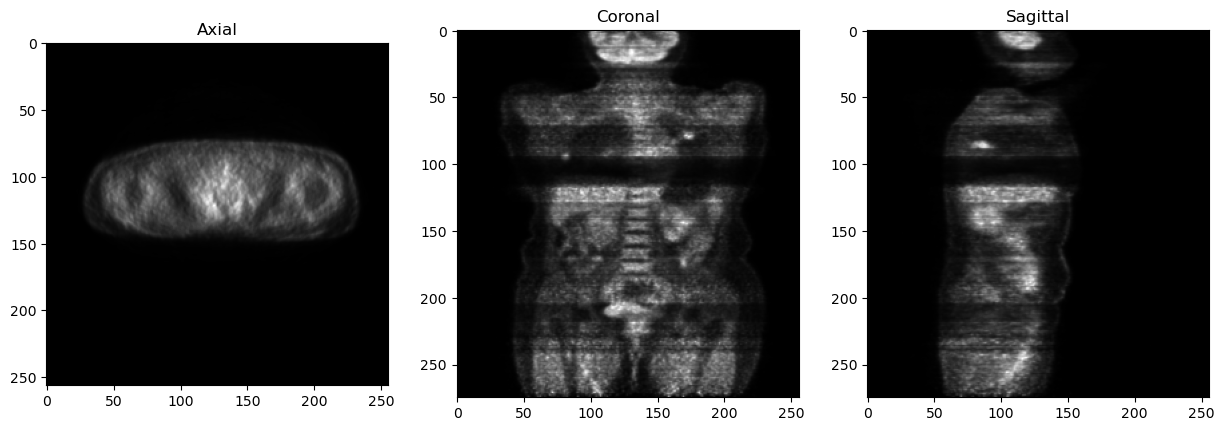

In [35]:
# plot three views of the image
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np_img[60], cmap='gray')
axs[0].set_title('Axial')
axs[1].imshow(np_img[:, 100], cmap='gray')
axs[1].set_title('Coronal')
axs[2].imshow(np_img[:, :, 100], cmap='gray')
axs[2].set_title('Sagittal')
plt.show()

In [ ]:
from scipy.ndimage import rotate, zoom 
import random
rotation_axis = random.choice([0, 1, 2]  # Randomly choose axis for rotation
rotation_angle = random.choice([90, 180, 270])  # Random rotation angle
np_img = rotate(np_img, rotation_angle, axes=(rotation_axis, (rotation_axis + 1) % 3), reshape=False)

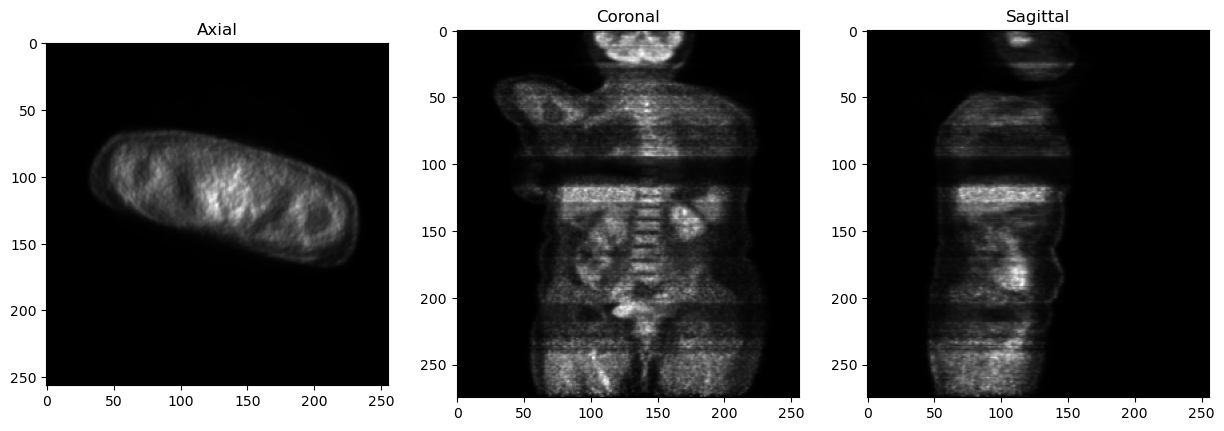

In [43]:

# plot three views of the image
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(np_img_ro[60], cmap='gray')
axs[0].set_title('Axial')
axs[1].imshow(np_img_ro[:, 100], cmap='gray')
axs[1].set_title('Coronal')
axs[2].imshow(np_img_ro[:, :, 100], cmap='gray')
axs[2].set_title('Sagittal')
plt.show()

In [45]:
np_img_ro = np_img_ro.clip(min=0)
np_img_ro.shape, np_img_ro.min(), np_img_ro.max()

((275, 256, 256), 0, 32767)

In [49]:
num_of_remove_slices = random.choice(range(10,21))

num_of_remove_slices_2 = random.choice(range(10,21))
image = np_img_ro[num_of_remove_slices:-num_of_remove_slices_2]

In [50]:
image.shape

(238, 256, 256)

In [ ]:
import torchio as tio

# Define a composition of transformations
transforms = tio.Compose([
    tio.RandomFlip(axes=('LR',), flip_probability=0.5),  # Flip along left-right axis
    # tio.RandomAffine(
    #     scales=(0.9, 1.1),   # Scale between 90% and 110%
    #     degrees=15          # Rotate up to ±15 degrees
    # ),
    # tio.RandomNoise(mean=0, std=0.1),                     # Add Gaussian noise
    # tio.RandomGamma(log_gamma=(-0.3, 0.3)),               # Adjust gamma values
    # tio.RandomElasticDeformation(num_control_points=7, max_displacement=7.5)  # Elastic deformation
])

# Apply transformations to a TorchIO ScalarImage (3D volume)
# Example: loading a volume might depend on your data loader/setup
# volume = tio.ScalarImage('path/to/volume.nii.gz')
# augmented_volume = transforms(volume)

In [ ]:
import torch
from torch.cuda.amp import GradScaler
import math
import sys
import time 
from tqdm import tqdm

import numpy as np
import os 

@torch.no_grad()
def generate_mask(loss_pred, gamma, epoch, total_epoch, guide = True):
    B, c, d, h, w = loss_pred.shape
    L = c * d * h * w
    loss_pred = loss_pred.view(B, L)

    len_keep = int(L * (1 - gamma))
 
    ids_shuffle_loss = torch.argsort(loss_pred, dim=1)  # (N, L)
    keep_ratio = 2/3
    ids_shuffle = torch.zeros_like(ids_shuffle_loss, device=loss_pred.device).int()
    len_loss = 0

    if guide:
        ### easy to hard
        keep_ratio = float((epoch + 1) / total_epoch) * 0.5

        ### hard-to-easy
        # keep_ratio = 0.5 - float(epoch / total_epoch) * 0.5

        ## top 0 -> 0.5
    
    for i in range(B):
        ## mask top `keep_ratio` loss and `1 - keep_ratio` random
        len_loss = int((L - len_keep) * keep_ratio)
        easy_len = int((L - len_keep)) - len_loss

        ids_shuffle[i, -len_loss:] = ids_shuffle_loss[i, -len_loss:]
        temp = torch.arange(L, device=loss_pred.device)
        deleted = np.delete(temp.cpu().numpy(), ids_shuffle[i, -len_loss:].cpu().numpy())
        np.random.shuffle(deleted)
        ids_shuffle[i, :(L - len_loss)] = torch.LongTensor(deleted).to(loss_pred.device)

    ids_restore = torch.argsort(ids_shuffle, dim=1)
    # generate mask: 1 is keep, 0 is remove
    mask = torch.zeros([B, L], device=loss_pred.device, dtype=torch.bool)  # Changed from ones to zeros
    mask[:, : len_keep] = 1  # Changed from 0 to 1
    # unshuffle to get final mask
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return mask.view(B, 1, d, h, w)


def generate_random_mask(input_size, mask_ratio, device='cuda'):
    """
    Generates a random binary mask for batched voxel data.

    Args:
        input_size (tuple): Shape of the input tensor (B, C, D, H, W).
        mask_ratio (float): Mask ratio in each data voxel (0.0 to 1.0).
        device (str, optional): Device to create the mask on ('cuda' or 'cpu'). Defaults to 'cuda'.

    Returns:
        torch.Tensor: Binary mask of the same shape as input_size.
                       1 indicates masked (kept), 0 indicates masked out.
    """
    assert len(input_size) == 5, "Input size should be (B, C, D, H, W) for batched voxels."
    B, C, D, H, W = input_size

    mask = torch.zeros(input_size, device=device) # Initialize mask with zeros

    for b in range(B):
        # Calculate total elements in a single voxel (C, D, H, W)
        voxel_size = (C, D, H, W)
        total_elements_voxel = torch.tensor(voxel_size).prod().item()
        num_ones_voxel = int(mask_ratio * total_elements_voxel)

        # Create a flat mask for the voxel
        mask_flat_voxel = torch.ones(total_elements_voxel, device=device)
        indices_voxel = torch.randperm(total_elements_voxel, device=device)[:num_ones_voxel]
        mask_flat_voxel[indices_voxel] = 0.0

        # Reshape the flat voxel mask back to (C, D, H, W) and assign to the batch
        mask[b, :, :, :, :] = mask_flat_voxel.view(voxel_size)

    return mask


def input_masked(input_tensor, mask):
    return input_tensor * mask


def forward_teacher_network(teacher_model, masked_input, original_input):
    with torch.no_grad():
        reconstruction = teacher_model(masked_input)
        L_rec = (reconstruction - original_input) ** 2  # Mean squared error per voxel
    return L_rec

def print_to_log_file(*args):
    print(*args)

def forward_loss(inp, rec, active_b1ff):
    mean = inp.mean(dim=-1, keepdim=True)
    var = inp.var(dim=-1, keepdim=True)
    inp = (inp - mean) / (var + 1.e-6) ** .5  #

    l2_loss = ((rec - inp) ** 2) 
    non_active = active_b1ff.logical_not().int()
    l2_loss = l2_loss
    recon_loss = l2_loss.mul_(non_active).sum() / (
            non_active.sum() + 1e-8)  # loss only on masked (non-active) patches

    return recon_loss

# Modified AnatomaSK training function with elements from both code snippets
def anatomask_training(
    model,
    model_ema,
    optimizer,
    scheduler,
    train_data_loader,
    n_epoch,
    gamma, # Masking ratio
    clip=1.0,
    alpha=0.9,
    AMP=True,
    device='cuda',
    res_dir = './results'
):
    """
    Main training function implementing the anatomask pipeline with dynamic masking ratio
    and EMA model updates.
    """

    os.makedirs(res_dir, exist_ok=True)

    epoch_loss = []
    epoch_ema_loss = []

    scaler = GradScaler() if AMP else None

    for i in tqdm(range(n_epoch)):
        model.train()
        per_loss = 0.0
        per_p_loss = 0.0

        print_to_log_file('')
        print_to_log_file(f'Epoch {i}')
        print_to_log_file()


        epoch_start_timestamps = time.time()
        if i < n_epoch // 4:
            model_ema.decay = 0.999 + i / (n_epoch // 4) * (0.9999 - 0.999)
        else:
            model_ema.decay = 0.9999



        

        #     if AMP:
        #         with torch.cuda.amp.autocast():
        #             # Generate random initial mask
        #             M_init = generate_random_mask(input_data.shape, gamma, device)
        #             masked_input = input_masked(input_data, M_init)

        #             # Forward through teacher (EMA) model to get reconstruction loss
        #             with torch.no_grad():
        #                 L_rec = forward_teacher_network(model_ema, masked_input, input_data)
        #             M_final = generate_mask(L_rec, gamma, epoch = i, total_epoch=n_epoch)
        #             # Mask input with final mask and train student network
        #             student_masked_input = input_masked(input_data, M_final)

        #             # Forward student model
        #             student_reconstruction = model(student_masked_input)
        #             loss = forward_loss(input_data, student_reconstruction, M_final)

        #         optimizer.zero_grad()
        #         scaler.scale(loss).backward()
        #         scaler.unscale_(optimizer)
        #         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #         scaler.step(optimizer)
        #         scaler.update()

        #     else:
        #         # Generate random initial mask
        #         M_init = generate_random_mask(input_data.shape, gamma, device)
        #         masked_input = input_masked(input_data, M_init)

        #         # Forward through teacher (EMA) model to get reconstruction loss
        #         with torch.no_grad():
        #             L_rec = forward_teacher_network(model_ema, masked_input, input_data)
                
        #         # Generate final mask based on reconstruction loss
        #         M_final = generate_mask(L_rec, gamma, epoch = i, total_epoch=n_epoch)
        #         # Mask input with final mask and train student network
        #         student_masked_input = input_masked(input_data, M_final)

        #         # Forward student model
        #         student_reconstruction = model(student_masked_input)
        #         loss = forward_loss(input_data, student_reconstruction, M_final)

        #         optimizer.zero_grad()
        #         loss.backward()
        #         torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #         optimizer.step()

        #     # Update EMA model
        #     model_ema.update(model)

        #     loss_value = loss.item()

        #     if not math.isfinite(loss_value):
        #         print(loss_value)
        #         print(f'Loss is {loss_value}, stopping training!')
        #         sys.exit(-1)

        #     per_loss += loss_value
        #     per_p_loss += loss_value

        #     torch.cuda.synchronize()

        # scheduler.step()
        # epoch_end_timestamps = time.time()

        # times = epoch_end_timestamps - epoch_start_timestamps
        # print_to_log_file(f'Epoch {i} took {times} seconds')

        # avg_loss = per_loss / len(train_data_loader)
        # epoch_loss.append(avg_loss)

        # # Calculate EMA loss
        # if i == 0:
        #     ema_loss = alpha * avg_loss + (1 - alpha) * avg_loss
        # else:
        #     ema_loss = alpha * epoch_ema_loss[-1] + (1 - alpha) * avg_loss

        # epoch_ema_loss.append(ema_loss)

        # # Save checkpoint
        # checkpoint = {
        #     'network_weights': model.state_dict(),
        #     'optimizer_state': optimizer.state_dict(),
        #     'grad_scaler_state': scaler.state_dict() if scaler else None,
        #     'train_loss': epoch_loss,
        #     'scheduler_state': scheduler.state_dict(),
        #     'current_epoch': i
        # }
        # torch.save(checkpoint, f'{res_dir}/model_checkpoint_epoch_{i}.pt')

    return model, model_ema, epoch_loss, epoch_ema_loss



In [ ]:
import copy
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch
from dataset import MedicalImageReportDataset
from torch.utils.data import DataLoader
from scheduler import LinearWarmupCosineAnnealingLR
# Initialize models, optimizer, and scheduler


# Create dataloader with dummy data
vision_ssl_paths = ['/home/user01/aiotlab/thaind/PET-CT-2022/split_body']
image_text_pairs_paths = ['/home/user01/aiotlab/thaind/DAC001_CTAC3.75mm_H_1001_PETWB3DAC001']





ds = MedicalImageReportDataset(vision_ssl_paths=vision_ssl_paths, image_text_pairs_path=image_text_pairs_paths, split='train', augment=True)
train_data_loader = DataLoader(ds, num_workers=4, batch_size=8, shuffle=True)

for batch in tqdm(train_data_loader):
    if batch is None:
        continue
    input_data = batch      



  0%|          | 0/979 [00:00<?, ?it/s]

16_0_/home/user01/aiotlab/thaind/DAC001_CTAC3.75mm_H_1001_PETWB3DAC001/THANG 6/images/chest/day_13_patient_721.npy

Error: Input and output sizes should be greater than 0, but got input (D: 0, H: 256, W: 256) output (D: 140, H: 480, W: 480) - /home/user01/aiotlab/thaind/DAC001_CTAC3.75mm_H_1001_PETWB3DAC001/THANG 6/images/chest/day_13_patient_721.npy


  0%|          | 1/979 [00:07<2:04:17,  7.63s/it]


KeyboardInterrupt: 

In [83]:
import random
from scipy.ndimage import rotate

def augment_rotation(image: np.array): 
    rotation_axis = random.choice([0,1,2])
    rotation_angle = random.choice(range(-15, 16))

    np_img = rotate(image, rotation_angle, axes=(rotation_axis, (rotation_axis + 1) % 3), reshape=False)

    return np_img

def load_with_augment(image_path: str):
    image = np.load(image_path)

    if random.random() < 0.5:
        return image 
    else:
        organ = image_path.split('/')[-2]
        num_of_remove_slices = random.choice(range(10,21))
        if organ == 'chest':
            num_of_remove_slices_2 = random.choice(range(1,21))
            print(num_of_remove_slices, num_of_remove_slices_2)
            image = image[num_of_remove_slices:]
            image = image[:-num_of_remove_slices_2]
            print(image.shape)
        elif organ == 'abdomen_pelvis':
            image = image[num_of_remove_slices:]
        elif organ == 'head_neck':
            image = image[:-num_of_remove_slices]
        else:
            raise ValueError(f"Invalid organ: {organ}")
    
    if random.random() < 0.5:
        return image
    else:
        return augment_rotation(image)

In [99]:
path = '/home/user01/aiotlab/thaind/DAC001_CTAC3.75mm_H_1001_PETWB3DAC001/THANG 9/images/chest/day_14_patient_1073.npy'
import numpy as np

np_img = load_with_augment(path)

np_img.shape

(142, 256, 256)

In [98]:
npImg = np.load(path)

npImg.shape

(142, 256, 256)

In [41]:
npImg = npImg[:-0]

In [42]:
npImg.shape

(0, 256, 256)

In [3]:
# get encoder checkpoint 
import torch
path1 = '/home/user10/huutien/simplified_anatomask/results/anatomask_100_epochs_8_batch_aug/model_checkpoint_epoch_9.pt'

checkpoint = torch.load(path1, map_location='cpu')

from cvit import CTViT
model = CTViT(
    dim = 512,
    codebook_size = 8192,
    image_size = 480,
    patch_size = 20,
    temporal_patch_size = 10,
    spatial_depth = 4,
    temporal_depth = 4,
    dim_head = 32,
    heads = 8
)

model.load_state_dict(checkpoint['network_weights'])



/tmp/ipykernel_2420028/868699663.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path1, map_location='cpu')
/home/user10/huutien/simplified_anato

<All keys matched successfully>

In [4]:
model.dec_temporal_transformer = None 
model.dec_spatial_transformer = None 

In [5]:
# savve model 

torch.save(model.state_dict(), '/home/user10/huutien/simplified_anatomask/results/anatomask_100_epochs_8_batch_aug/encoder_only_9.pt')